C:\Users\Sedat\PycharmProjects\mining-quality-prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Veri hazırlandı.
Model şuradan yüklendi: ../models/final_xgboost_model.pkl
SHAP analizi hesaplanıyor... (Biraz sürebilir)


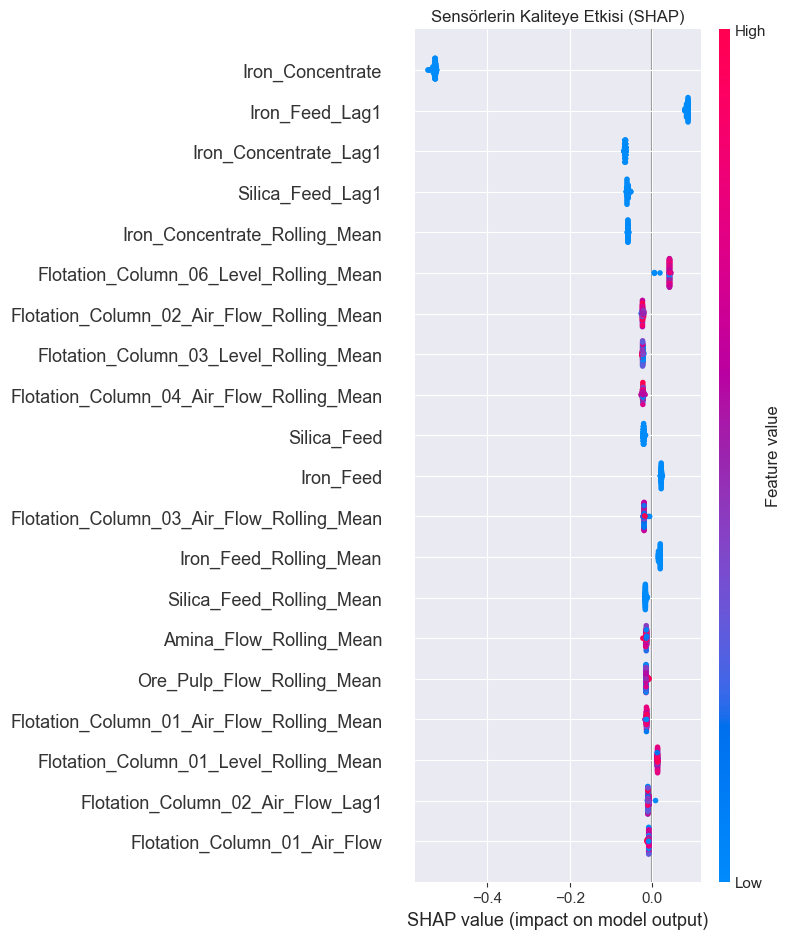


--- EN KRİTİK SENSÖR TESPİT EDİLDİ: Iron_Concentrate ---
Senaryo: Iron_Concentrate değeri 66.04 -> 52.83 yapılırsa:
Tahmini Silika (Safsızlık): 1.53 -> 3.56
Değişim: 2.0251
SONUÇ: Silika oranı arttı. Kalite KÖTÜLEŞTİ! ❌


In [1]:
# Hücre 1: Kütüphaneler
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

# Hücre 2: Veriyi Hazırla (Model eğitimiyle birebir aynı olmalı)
# Veriyi Oku
df = pd.read_csv(r'C:\Users\Sedat\PycharmProjects\mining-quality-prediction\data\MiningProcess_Flotation_Plant_Database.csv', decimal=',')
df.columns = [col.replace(' ', '_').replace('%_', '').replace('(', '').replace(')', '') for col in df.columns]
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values('date')

# Feature Engineering
input_cols = [col for col in df.columns if col not in ['date', 'Silica_Concentrate']]
for col in input_cols:
    df[f'{col}_Rolling_Mean'] = df[col].rolling(window=5).mean()
    df[f'{col}_Lag1'] = df[col].shift(1)

df = df.dropna()

# X ve y ayır
X = df.drop(['date', 'Silica_Concentrate'], axis=1)
y = df['Silica_Concentrate']

# Test setini ayır (shuffle=False ile, modelin hiç görmediği son kısım)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=42)

print("Veri hazırlandı.")

# Hücre 3: Modeli Yükle
model_path = '../models/final_xgboost_model.pkl'
loaded_model = joblib.load(model_path)
print(f"Model şuradan yüklendi: {model_path}")

# Hücre 4: SHAP Analizi (Modelin Karar Mekanizması)
# Hız için test setinin sadece ilk 100 örneğini kullanacağız
print("SHAP analizi hesaplanıyor... (Biraz sürebilir)")
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(X_test.iloc[:100])

# Özet Grafik (Summary Plot)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test.iloc[:100], show=False)
plt.title("Sensörlerin Kaliteye Etkisi (SHAP)")
plt.tight_layout()
plt.show()

# Hücre 5: Business Simülasyonu (Senaryo Analizi)
# En önemli özelliği bul (SHAP değerlerinin ortalamasına göre)
# Bu kod otomatik olarak en etkili sensörü bulur
feature_importance = np.abs(shap_values).mean(0)
top_feature_idx = np.argsort(feature_importance)[-1] # En yüksek etkiye sahip index
top_feature_name = X_test.columns[top_feature_idx]

print(f"\n--- EN KRİTİK SENSÖR TESPİT EDİLDİ: {top_feature_name} ---")

# Simülasyon: Bu sensörün değerini %20 düşürürsek ne olur?
sample_idx = 0 # Test setinin ilk satırını al
sample_row = X_test.iloc[[sample_idx]].copy()
original_pred = loaded_model.predict(sample_row)[0]

# Değeri değiştir
old_value = sample_row[top_feature_name].values[0]
new_value = old_value * 0.80 # %20 düşür
sample_row[top_feature_name] = new_value

new_pred = loaded_model.predict(sample_row)[0]
change = new_pred - original_pred

print(f"Senaryo: {top_feature_name} değeri {old_value:.2f} -> {new_value:.2f} yapılırsa:")
print(f"Tahmini Silika (Safsızlık): {original_pred:.2f} -> {new_pred:.2f}")
print(f"Değişim: {change:.4f}")

if change < 0:
    print("SONUÇ: Silika oranı düştü. Kalite İYİLEŞTİ! ✅")
else:
    print("SONUÇ: Silika oranı arttı. Kalite KÖTÜLEŞTİ! ❌")